# 데이터 로드

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shap
import random

random.seed(42)
np.random.seed(42)


plt.rcParams['font.family'] = ['Malgun Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False



In [12]:
df = pd.read_csv('data_2.csv', dtype={'isbn': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               3316 non-null   object 
 1   title              3316 non-null   object 
 2   publishDate        3316 non-null   int64  
 3   price              3316 non-null   int64  
 4   pageCount          3316 non-null   int64  
 5   size               3316 non-null   float64
 6   weight             3316 non-null   int64  
 7   label              3316 non-null   int64  
 8   author_name_tf     3316 non-null   int64  
 9   publisher_name_tf  3316 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 259.2+ KB


In [13]:
df.head()
df.describe()
df.isnull().sum()

isbn                 0
title                0
publishDate          0
price                0
pageCount            0
size                 0
weight               0
label                0
author_name_tf       0
publisher_name_tf    0
dtype: int64

In [14]:
# 두 CSV 파일 불러오기 (isbn을 문자열로 처리)
keyword_best = pd.read_csv('book_with_entropy.csv', dtype={'isbn': str})
keyword_book = pd.read_csv('일반도서 entropy.csv', dtype={'isbn': str})

# 컬럼 이름 확인
best_columns = keyword_best.columns.tolist()
book_columns = keyword_book.columns.tolist()

best_columns, book_columns

(['topic_0',
  'topic_1',
  'topic_2',
  'topic_3',
  'topic_4',
  'topic_5',
  'isbn',
  'entropy'],
 ['topic_0',
  'topic_1',
  'topic_2',
  'topic_3',
  'topic_4',
  'topic_5',
  'isbn',
  'entropy'])

In [15]:
df_best = df[df['label'] == 1].copy()
df_book = df[df['label'] == 0].copy()

print("베스트셀러 수:", len(df_best))
print("일반 도서 수:", len(df_book))

베스트셀러 수: 1000
일반 도서 수: 2316


In [16]:
df_best = df_best.merge(keyword_best, on='isbn', how='left')
df_book = df_book.merge(keyword_book, on='isbn', how='left')

In [17]:
df = pd.concat([df_best, df_book], ignore_index=True)
print(df.shape)

(3316, 17)


# 이상치

# XGB

In [18]:
# 토픽 컬럼 리스트
topic_cols = ['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_0']

# 토픽 컬럼 중 하나라도 결측치가 있으면 그 행 제거
df = df.dropna(subset=topic_cols).reset_index(drop=True)

In [19]:
# 지수변환, 엔트로피

# 1. 토픽값에 지수 변환 (exp, 0값 방지용 eps 추가)
eps = 1e-5
for col in topic_cols:
    df[col + '_exp'] = np.exp(df[col].replace(0, eps) + eps)

# 2. 엔트로피 정규화 (0~1)
max_entropy = np.log2(len(topic_cols))
df['entropy_norm'] = df['entropy'] / max_entropy

# 3. 1 - 엔트로피 정규화값 계산
df['inv_entropy'] = 1 - df['entropy_norm']

# 4. k제곱 후, 지수 변환된 토픽값에 곱하기
k = 1
for col in topic_cols:
    df[f'{col}_ent'] = df[col + '_exp'] * (df['inv_entropy'] ** k)

# 5. 기존 토픽 컬럼, 엔트로피 관련 컬럼, 지수 변환만 한 컬럼 제외
drop_cols = topic_cols + ['entropy', 'entropy_norm', 'inv_entropy'] + [col + '_exp' for col in topic_cols]
X = df.drop(columns=drop_cols + ['isbn', 'title', 'label'])
y = df['label']

# 6. 결과 확인
print("최종 학습셋 피처 목록:", X.columns.tolist())
print(X[[f'{col}_ent' for col in topic_cols]].head())


최종 학습셋 피처 목록: ['publishDate', 'price', 'pageCount', 'size', 'weight', 'author_name_tf', 'publisher_name_tf', 'topic_1_ent', 'topic_2_ent', 'topic_3_ent', 'topic_4_ent', 'topic_5_ent', 'topic_0_ent']
   topic_1_ent  topic_2_ent  topic_3_ent  topic_4_ent  topic_5_ent  \
0     0.913930     0.916651     0.916384     0.915493     2.414208   
1     0.939636     0.493784     0.574116     0.603887     0.493637   
2     0.653480     0.653702     1.324400     0.653607     0.873885   
3     2.623111     0.973009     0.972937     0.972695     0.972463   
4     0.634478     1.245323     0.874361     0.634705     0.634581   

   topic_0_ent  
0     0.916387  
1     0.493764  
2     0.653680  
3     0.972937  
4     0.634834  


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)
print("최종 feature 목록:", X_train.columns.tolist())

Train shape: (1138, 13)
Validation shape: (326, 13)
Test shape: (163, 13)
최종 feature 목록: ['publishDate', 'price', 'pageCount', 'size', 'weight', 'author_name_tf', 'publisher_name_tf', 'topic_1_ent', 'topic_2_ent', 'topic_3_ent', 'topic_4_ent', 'topic_5_ent', 'topic_0_ent']


In [21]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1️⃣ 기본 모델
basic_model = RandomForestClassifier(random_state=42, n_jobs=-1)
basic_model.fit(X_train, y_train)
y_val_pred_basic = basic_model.predict(X_val)

results = []
results.append({
    'name': 'RF_baseline',
    'model': basic_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_basic),
    'report': classification_report(y_val, y_val_pred_basic, output_dict=False)
})

# 2️⃣ Optuna 목적 함수
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# 3️⃣ Optuna 최적화 실행
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# 4️⃣ 최적 모델 학습
best_params = study.best_trial.params
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

y_val_pred_tuned = best_model.predict(X_val)

results.append({
    'name': 'RF_optuna',
    'model': best_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_tuned),
    'report': classification_report(y_val, y_val_pred_tuned, output_dict=False),
    'best_params': best_params
})

# 5️⃣ 결과 출력
for res in results:
    print(f"\n==== {res['name']} ====")
    print(res['conf_matrix'])
    print(res['report'])
    if 'best_params' in res:
        print("Best Params:", res['best_params'])


[I 2025-06-09 16:32:25,897] A new study created in memory with name: no-name-bf52dfd2-ebee-4b5b-9c6f-ae3b8eb0c6dc
Best trial: 0. Best value: 0.920245:   2%|▏         | 1/50 [00:00<00:28,  1.74it/s]

[I 2025-06-09 16:32:26,470] Trial 0 finished with value: 0.9202453987730062 and parameters: {'n_estimators': 250, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9202453987730062.


Best trial: 0. Best value: 0.920245:   4%|▍         | 2/50 [00:01<00:31,  1.55it/s]

[I 2025-06-09 16:32:27,169] Trial 1 finished with value: 0.8773006134969326 and parameters: {'n_estimators': 383, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9202453987730062.


Best trial: 0. Best value: 0.920245:   6%|▌         | 3/50 [00:02<00:37,  1.26it/s]

[I 2025-06-09 16:32:28,141] Trial 2 finished with value: 0.9049079754601227 and parameters: {'n_estimators': 273, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.9202453987730062.


Best trial: 0. Best value: 0.920245:   8%|▊         | 4/50 [00:03<00:38,  1.18it/s]

[I 2025-06-09 16:32:29,062] Trial 3 finished with value: 0.9141104294478528 and parameters: {'n_estimators': 306, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.9202453987730062.


Best trial: 0. Best value: 0.920245:  10%|█         | 5/50 [00:03<00:34,  1.31it/s]

[I 2025-06-09 16:32:29,691] Trial 4 finished with value: 0.901840490797546 and parameters: {'n_estimators': 222, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.9202453987730062.


Best trial: 5. Best value: 0.923313:  12%|█▏        | 6/50 [00:04<00:34,  1.26it/s]

[I 2025-06-09 16:32:30,532] Trial 5 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 365, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  14%|█▍        | 7/50 [00:06<00:45,  1.06s/it]

[I 2025-06-09 16:32:32,140] Trial 6 finished with value: 0.8374233128834356 and parameters: {'n_estimators': 339, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  16%|█▌        | 8/50 [00:07<00:41,  1.01it/s]

[I 2025-06-09 16:32:32,986] Trial 7 finished with value: 0.9141104294478528 and parameters: {'n_estimators': 243, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  18%|█▊        | 9/50 [00:07<00:31,  1.32it/s]

[I 2025-06-09 16:32:33,231] Trial 8 finished with value: 0.9202453987730062 and parameters: {'n_estimators': 102, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  20%|██        | 10/50 [00:08<00:29,  1.34it/s]

[I 2025-06-09 16:32:33,961] Trial 9 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 349, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  22%|██▏       | 11/50 [00:08<00:31,  1.25it/s]

[I 2025-06-09 16:32:34,868] Trial 10 finished with value: 0.9202453987730062 and parameters: {'n_estimators': 486, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  24%|██▍       | 12/50 [00:09<00:31,  1.21it/s]

[I 2025-06-09 16:32:35,765] Trial 11 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 415, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  26%|██▌       | 13/50 [00:10<00:32,  1.13it/s]

[I 2025-06-09 16:32:36,783] Trial 12 finished with value: 0.9202453987730062 and parameters: {'n_estimators': 426, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  28%|██▊       | 14/50 [00:11<00:31,  1.13it/s]

[I 2025-06-09 16:32:37,659] Trial 13 finished with value: 0.9141104294478528 and parameters: {'n_estimators': 363, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  30%|███       | 15/50 [00:12<00:26,  1.34it/s]

[I 2025-06-09 16:32:38,093] Trial 14 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 183, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  32%|███▏      | 16/50 [00:13<00:30,  1.12it/s]

[I 2025-06-09 16:32:39,331] Trial 15 finished with value: 0.9141104294478528 and parameters: {'n_estimators': 491, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  34%|███▍      | 17/50 [00:14<00:29,  1.11it/s]

[I 2025-06-09 16:32:40,250] Trial 16 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 318, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  36%|███▌      | 18/50 [00:15<00:30,  1.04it/s]

[I 2025-06-09 16:32:41,355] Trial 17 finished with value: 0.9141104294478528 and parameters: {'n_estimators': 432, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 5. Best value: 0.923313:  38%|███▊      | 19/50 [00:16<00:28,  1.09it/s]

[I 2025-06-09 16:32:42,170] Trial 18 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 378, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 5 with value: 0.9233128834355828.


Best trial: 19. Best value: 0.929448:  40%|████      | 20/50 [00:16<00:25,  1.18it/s]

[I 2025-06-09 16:32:42,860] Trial 19 finished with value: 0.9294478527607362 and parameters: {'n_estimators': 284, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  42%|████▏     | 21/50 [00:17<00:20,  1.44it/s]

[I 2025-06-09 16:32:43,194] Trial 20 finished with value: 0.9171779141104295 and parameters: {'n_estimators': 123, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  44%|████▍     | 22/50 [00:17<00:18,  1.48it/s]

[I 2025-06-09 16:32:43,816] Trial 21 finished with value: 0.9294478527607362 and parameters: {'n_estimators': 288, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  46%|████▌     | 23/50 [00:18<00:16,  1.68it/s]

[I 2025-06-09 16:32:44,235] Trial 22 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 187, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  48%|████▊     | 24/50 [00:18<00:15,  1.66it/s]

[I 2025-06-09 16:32:44,852] Trial 23 finished with value: 0.9171779141104295 and parameters: {'n_estimators': 284, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  50%|█████     | 25/50 [00:19<00:15,  1.60it/s]

[I 2025-06-09 16:32:45,533] Trial 24 finished with value: 0.9202453987730062 and parameters: {'n_estimators': 320, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  52%|█████▏    | 26/50 [00:20<00:14,  1.61it/s]

[I 2025-06-09 16:32:46,131] Trial 25 finished with value: 0.9202453987730062 and parameters: {'n_estimators': 278, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  54%|█████▍    | 27/50 [00:20<00:12,  1.80it/s]

[I 2025-06-09 16:32:46,546] Trial 26 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  56%|█████▌    | 28/50 [00:21<00:14,  1.55it/s]

[I 2025-06-09 16:32:47,387] Trial 27 finished with value: 0.9263803680981595 and parameters: {'n_estimators': 395, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  58%|█████▊    | 29/50 [00:22<00:15,  1.36it/s]

[I 2025-06-09 16:32:48,344] Trial 28 finished with value: 0.9202453987730062 and parameters: {'n_estimators': 464, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  60%|██████    | 30/50 [00:22<00:13,  1.50it/s]

[I 2025-06-09 16:32:48,850] Trial 29 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 234, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  62%|██████▏   | 31/50 [00:23<00:12,  1.47it/s]

[I 2025-06-09 16:32:49,564] Trial 30 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 334, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  64%|██████▍   | 32/50 [00:24<00:13,  1.36it/s]

[I 2025-06-09 16:32:50,419] Trial 31 finished with value: 0.9263803680981595 and parameters: {'n_estimators': 409, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  66%|██████▌   | 33/50 [00:25<00:13,  1.31it/s]

[I 2025-06-09 16:32:51,262] Trial 32 finished with value: 0.9263803680981595 and parameters: {'n_estimators': 400, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  68%|██████▊   | 34/50 [00:26<00:12,  1.23it/s]

[I 2025-06-09 16:32:52,183] Trial 33 finished with value: 0.9263803680981595 and parameters: {'n_estimators': 443, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 19. Best value: 0.929448:  70%|███████   | 35/50 [00:26<00:11,  1.35it/s]

[I 2025-06-09 16:32:52,748] Trial 34 finished with value: 0.9263803680981595 and parameters: {'n_estimators': 260, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 19 with value: 0.9294478527607362.


Best trial: 35. Best value: 0.932515:  72%|███████▏  | 36/50 [00:27<00:10,  1.31it/s]

[I 2025-06-09 16:32:53,566] Trial 35 finished with value: 0.9325153374233128 and parameters: {'n_estimators': 392, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  74%|███████▍  | 37/50 [00:28<00:09,  1.41it/s]

[I 2025-06-09 16:32:54,146] Trial 36 finished with value: 0.9202453987730062 and parameters: {'n_estimators': 298, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  76%|███████▌  | 38/50 [00:29<00:09,  1.22it/s]

[I 2025-06-09 16:32:55,235] Trial 37 finished with value: 0.901840490797546 and parameters: {'n_estimators': 385, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  78%|███████▊  | 39/50 [00:29<00:08,  1.30it/s]

[I 2025-06-09 16:32:55,891] Trial 38 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 300, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  80%|████████  | 40/50 [00:30<00:07,  1.29it/s]

[I 2025-06-09 16:32:56,667] Trial 39 finished with value: 0.9141104294478528 and parameters: {'n_estimators': 263, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  82%|████████▏ | 41/50 [00:31<00:06,  1.49it/s]

[I 2025-06-09 16:32:57,102] Trial 40 finished with value: 0.9202453987730062 and parameters: {'n_estimators': 217, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  84%|████████▍ | 42/50 [00:32<00:05,  1.38it/s]

[I 2025-06-09 16:32:57,940] Trial 41 finished with value: 0.9263803680981595 and parameters: {'n_estimators': 401, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  86%|████████▌ | 43/50 [00:32<00:05,  1.37it/s]

[I 2025-06-09 16:32:58,696] Trial 42 finished with value: 0.9263803680981595 and parameters: {'n_estimators': 355, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  88%|████████▊ | 44/50 [00:33<00:04,  1.29it/s]

[I 2025-06-09 16:32:59,564] Trial 43 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 384, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  90%|█████████ | 45/50 [00:34<00:04,  1.21it/s]

[I 2025-06-09 16:33:00,527] Trial 44 finished with value: 0.9325153374233128 and parameters: {'n_estimators': 467, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  92%|█████████▏| 46/50 [00:35<00:03,  1.16it/s]

[I 2025-06-09 16:33:01,456] Trial 45 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 463, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  94%|█████████▍| 47/50 [00:36<00:02,  1.03it/s]

[I 2025-06-09 16:33:02,684] Trial 46 finished with value: 0.911042944785276 and parameters: {'n_estimators': 448, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  96%|█████████▌| 48/50 [00:37<00:01,  1.12it/s]

[I 2025-06-09 16:33:03,391] Trial 47 finished with value: 0.9325153374233128 and parameters: {'n_estimators': 338, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515:  98%|█████████▊| 49/50 [00:38<00:00,  1.24it/s]

[I 2025-06-09 16:33:04,011] Trial 48 finished with value: 0.9233128834355828 and parameters: {'n_estimators': 330, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 35 with value: 0.9325153374233128.


Best trial: 35. Best value: 0.932515: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


[I 2025-06-09 16:33:04,618] Trial 49 finished with value: 0.9294478527607362 and parameters: {'n_estimators': 288, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 35 with value: 0.9325153374233128.

==== RF_baseline ====
[[109  16]
 [  8 193]]
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       125
           1       0.92      0.96      0.94       201

    accuracy                           0.93       326
   macro avg       0.93      0.92      0.92       326
weighted avg       0.93      0.93      0.93       326


==== RF_optuna ====
[[111  14]
 [  8 193]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       125
           1       0.93      0.96      0.95       201

    accuracy                           0.93       326
   macro avg       0.93      0.92      0.93       326
weighted avg       0.93      0.93      

In [22]:
# # 원본 데이터 df에서 validation 인덱스만 추출
# isbn_val = df.loc[X_val.index, 'isbn']

# output_df = pd.DataFrame({
#     'isbn': isbn_val.values,
#     'y_pred': y_pred
# })

# output_df.to_csv('y_pred.csv', index=False)


In [23]:
print("Train Accuracy:", accuracy_score(y_train, best_model.predict(X_train)))
print("Val Accuracy:", accuracy_score(y_val, best_model.predict(X_val)))
print("Test Accuracy:", accuracy_score(y_test, best_model.predict(X_test)))

Train Accuracy: 0.953427065026362
Val Accuracy: 0.9325153374233128
Test Accuracy: 0.9141104294478528


C:\Users\학부연구생\AppData\Local\Temp\ipykernel_12312\1579341922.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_best, X_val, feature_names=X_val.columns.tolist())


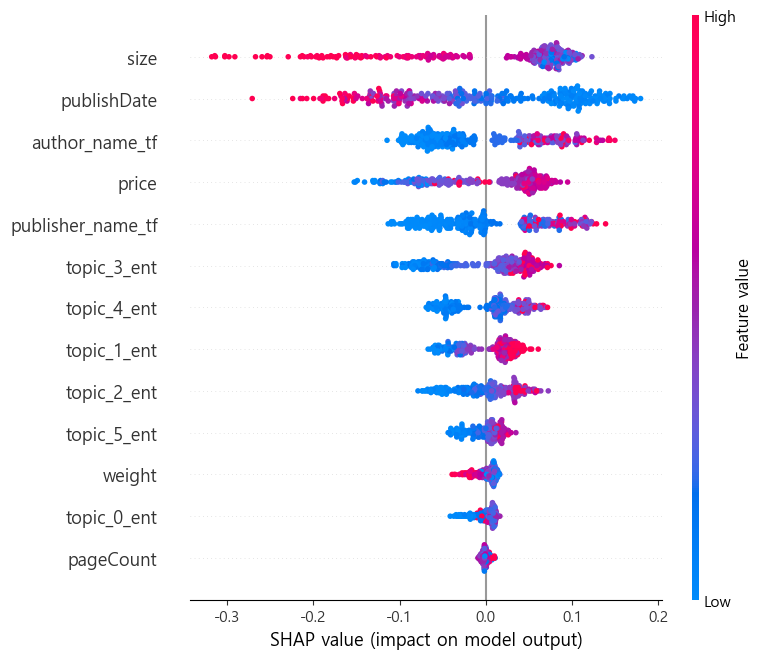

C:\Users\학부연구생\AppData\Local\Temp\ipykernel_12312\1579341922.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_best, X_val, plot_type="bar", feature_names=X_val.columns.tolist())


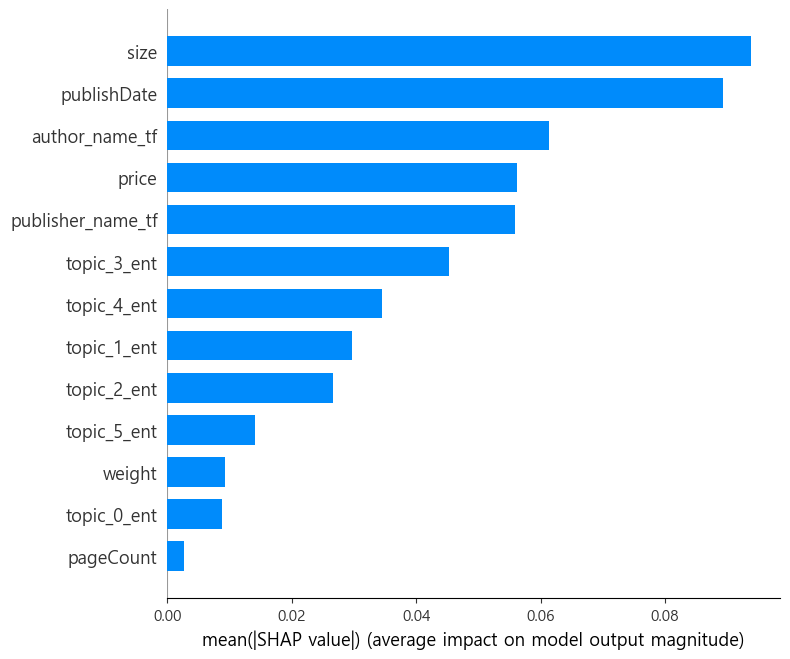

In [24]:
import shap

# 1. SHAP 값 계산 (3차원 배열)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val)  # shape: (663, 13, 2)

# 2. 클래스 1(베스트셀러) SHAP 값 추출
shap_values_best = shap_values[:, :, 1]  # shape: (663, 13)

# 3. 시각화
shap.summary_plot(shap_values_best, X_val, feature_names=X_val.columns.tolist())
shap.summary_plot(shap_values_best, X_val, plot_type="bar", feature_names=X_val.columns.tolist())